### SVD approach of Recommender system

* Considering a host(user)-resource matrix $M_{ij}$ with the matrix element being the #DL. The simplest recommender system is the SVD. 

* In this example, I first prepare the table for the host(user) and resource(data), then SVD the highly sparse matrix
\begin{align}
M_{ij} = \sum_k H_{ik}D_{kk}R_{kj},
\end{align}
and infer the user preference from the $H_ik$, which means the "rating" of user-$i$ on the data-$k$.

* More data is needed for a higher quality of recommenation. 

* TODO: Recommender system based-on neuron network....


Sparsity: 0.999669


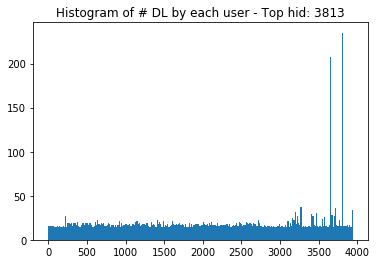

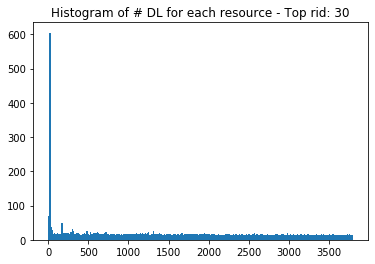

In [13]:
#!/usr/bin/python
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from collections import Counter

F_HR_MAT = "hr_mat.dat"
def load_hr_mat(): 
    """
    Load "Host-Resource-#DL table to build the sparse matrix"
    """
    return np.loadtxt(open(F_HR_MAT, "r"), delimiter=",", skiprows=0, dtype=int)


def build_sparse_mat(d):
    rid = d[:,1]-1   ## make rid start from 0
    smat = scipy.sparse.csr_matrix( ( d[:,2].astype(float), (d[:,0].astype(int), rid.astype(int))) )
    print ("Data shape: ", d.shape, smat.shape)
    print("Max/Min host: ", np.min(data[:,0]), np.max(data[:,0]) )
    print("Max/Min item: ", np.min(rid), np.max(rid) )          
    print("Max/Min data: ", np.min(data[:,2]), np.max(data[:,2]) )
    return smat

def eda():
    """
    A glance of data
    """
    data = load_hr_mat()
    print("Sparsity: %.6f" % (1 - len(data)/(np.max(data[:,0])*np.max(data[:,1]))     ) )
    plt.figure()
    plt.hist(data[:,0], bins=256)
    top = Counter(data[:,0]).most_common(1)
    plt.title("Histogram of # DL by each user - Top hid: %d" % top[0][0])
    plt.figure()
    plt.hist(data[:,1], bins=256)
    top = Counter(data[:,1]).most_common(1)
    plt.title("Histogram of # DL for each resource - Top rid: %d" % top[0][0])
    plt.show()
    
def svd(train, k):
    utilMat = np.array(train)
    # the nan or unavailable entries are masked
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1))
    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    utilMat = utilMat - x
    # The magic happens here. U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)
    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    UsV = np.dot(np.dot(U,s), V)
    UsV = UsV + x
    print("svd done")
    return UsV

eda()


In [16]:
import  scipy.sparse.linalg

data = load_hr_mat()
smat = build_sparse_mat(data)


###########################3
global_average = smat.sum()/smat.count_nonzero()
print ("Avg #DL over all item: ", global_average)

# Simple SVD approach for recommendation
U, sigma, Vt = scipy.sparse.linalg.svds(smat, k = 128)
smat1 = U.dot(np.diag(sigma)).dot(Vt)

Data shape:  (4954, 3) (3945, 3796)
Max/Min host:  0 3944
Max/Min item:  0 3795
Max/Min data:  1 1
Avg #DL over all item:  1.0


In [26]:
##  Top-10 for a given Host-ID
idx=150
print(smat.todense()[idx,:].sum())
print(smat.todense()[idx,:].argmax())
print(np.argsort(smat1[idx,:])[::-1][:10] )

### For IDX higher than the min-k, the result is really. This may due to the insufficienct data for a minial SVD.

1.0
203
[ 203 2926 3234  967 3387 1058 2607 1317 1474 2564]


In [6]:
#############
def test():
    row = np.array([0, 1, 2])
    col = np.array([0, 1, 2])
    data = np.array([1., 1., 1.9])
    A = scipy.sparse.csr_matrix((data, (row, col)) )
    print(A.todense())
    U, D, V = scipy.sparse.linalg.svds(A, k = 2)
    print(U.dot(np.diag(D).dot(V)))
##############

test()


[[1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1.9]]
[[ 1.82135778e-01  3.85956392e-01 -1.43687061e-16]
 [ 3.85956392e-01  8.17864222e-01 -4.29933716e-18]
 [-7.56247688e-17 -2.26280903e-18  1.90000000e+00]]
